## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch 
from torch import nn 

torch.__version__


'2.7.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import requests
import zipfile 
from pathlib import Path

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip" , "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


## 2. Become one with the data (data preparation)

In [4]:
import os 
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

        

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2.1 Visualize an image

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


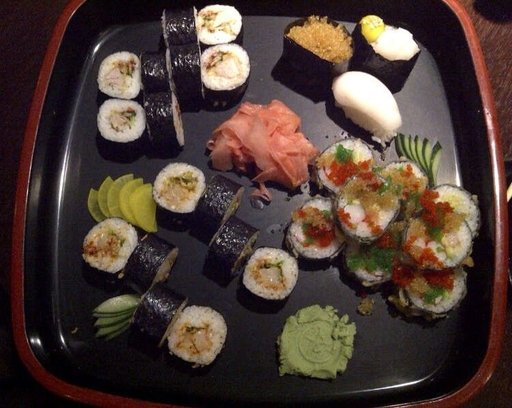

In [7]:
import random 
from PIL import Image

random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem # The stem attribute is used to get the name of a file without its extension, but it cannot be applied directly to a directory

# Open image 
img = Image.open(random_image_path)

# Print meta 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

- We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first.

(-0.5, 511.5, 407.5, -0.5)

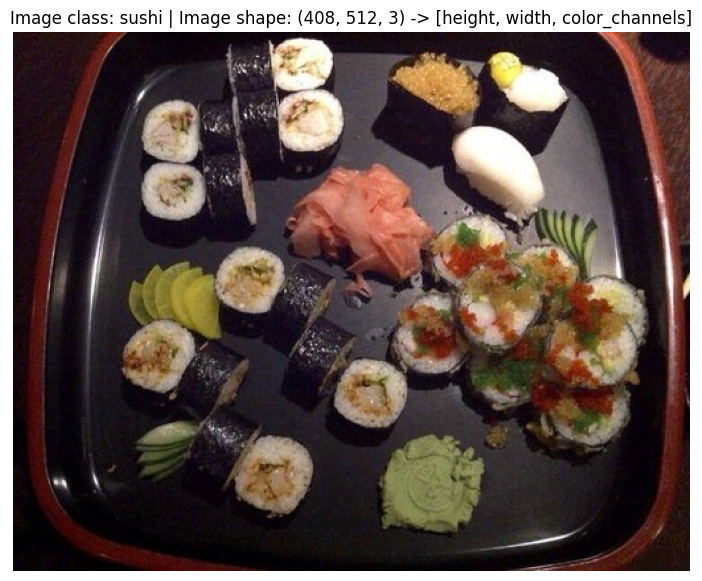

In [8]:
import numpy as np 
import matplotlib.pyplot as plt 

# turn the image as an array 
img_as_arr = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_arr)
plt.title(f"Image class: {image_class} | Image shape: {img_as_arr.shape} -> [height, width, color_channels]")
plt.axis(False)

## 3.Trasforming data

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with torchvision.transforms

In [10]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

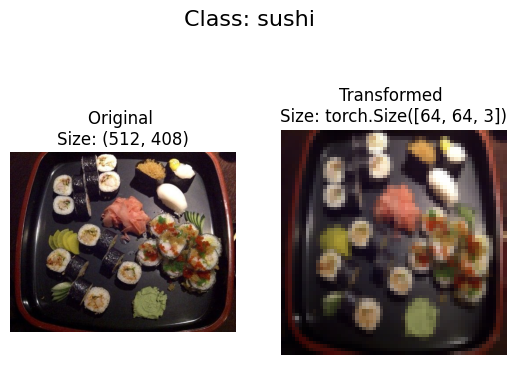

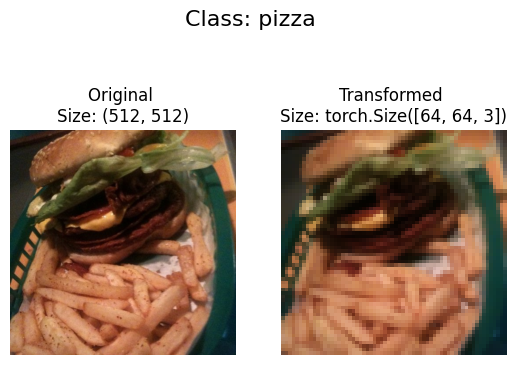

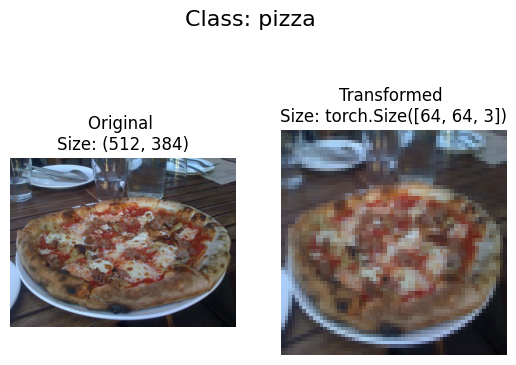

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(42)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list, transform=data_transform, n = 3)

- Generally, the larger the shape of the image, the more information a model can recover.

- For example, an image of size [256, 256, 3] will have 16x more pixels than an image of size [64, 64, 3] ((256*256*3)/(64*64*3)=16).

- However, the tradeoff is that more pixels requires more computations.

## 4. Option 1: Loading Image Data Using ImageFolder

In [12]:
# return list of pairs (img, lable)
train_data = datasets.ImageFolder(root = train_dir,
                                 transform=data_transform,
                                 target_transform=None) # transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root = test_dir,
                                transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
len(train_data), len(test_data)

(225, 75)

In [16]:
img, label = train_data[0]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Text(0.5, 1.0, 'pizza')

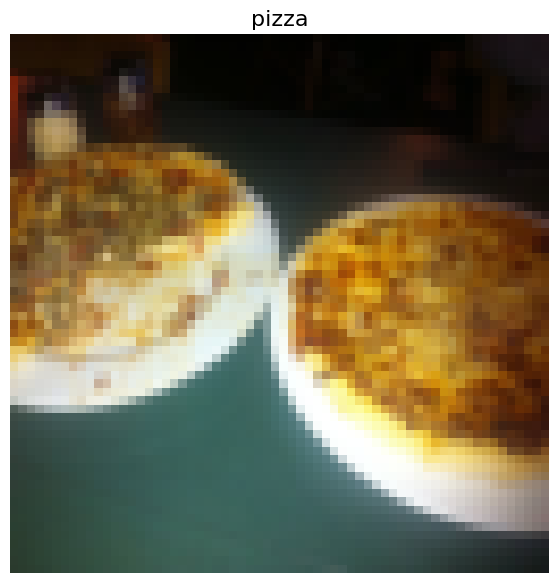

In [17]:
# Plot the image 
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label], fontsize=16)

## 4.1 Turn loaded images into DataLoader's
- What's num_workers?

- Good question.

- It defines how many subprocesses will be created to load your data.

- Think of it like this, the higher value num_workers is set to, the more compute power PyTorch will use to load your data.

- Personally, I usually set it to the total number of CPUs on my machine via Python's os.cpu_count().

- This ensures the DataLoader recruits as many cores as possible to load da

In [18]:
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=1,
                            num_workers=1,
                            shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2116e7e40b0>,
 <torch.utils.data.dataloader.DataLoader at 0x2116e750e30>)

In [19]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom Dataset

In [20]:
import os 
import pathlib 
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Tuple, Dict


In [21]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [22]:
target_dir = train_dir
print(f"Target directory: {target_dir}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
print(f"Class names found: {class_names_found}")

Target directory: data\pizza_steak_sushi\train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [24]:

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder

In [25]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform 
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [26]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2116ec92750>,
 <__main__.ImageFolderCustom at 0x2116ecd11c0>)

In [28]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [29]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [30]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

In [31]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset, 
                         classes: List[str] = None, 
                         n: int = 10, 
                         display_shape: bool = True, 
                         seed: int = None):
    if n > 10:
        n = 10 
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        ramdom.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample] 

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1,n, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

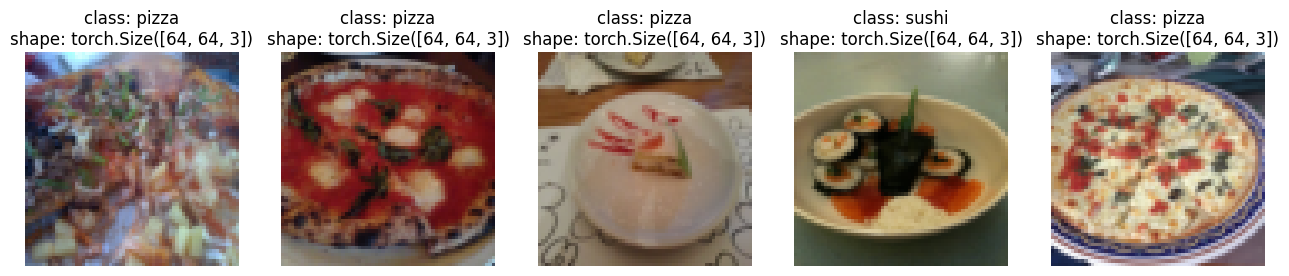

In [32]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into DataLoader's

In [33]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(train_data_custom, batch_size=1, num_workers=0, shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom, batch_size=1, num_workers=0, shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2116e818110>,
 <torch.utils.data.dataloader.DataLoader at 0x2116e930290>)

In [34]:
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 6. Other forms of transforms (data augmentation)
- Machine learning is all about harnessing the power of randomness and research shows that random transforms (like transforms.RandAugment() and transforms.TrivialAugmentWide()) generally perform better than hand-picked transforms

In [35]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor()    
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

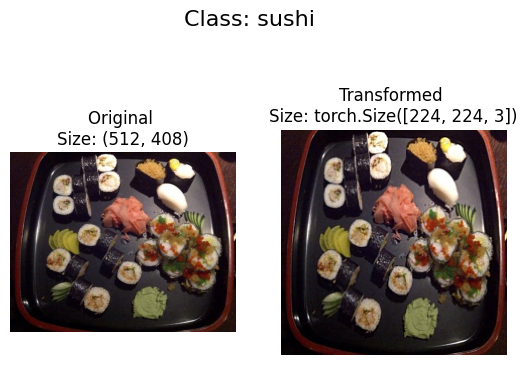

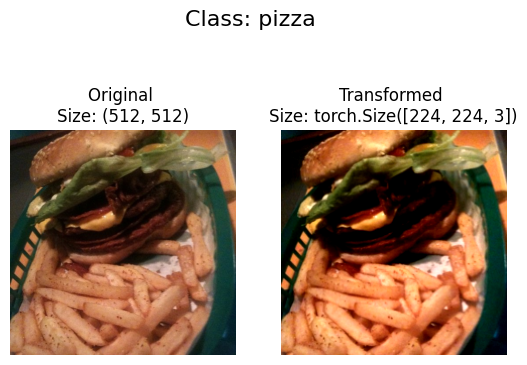

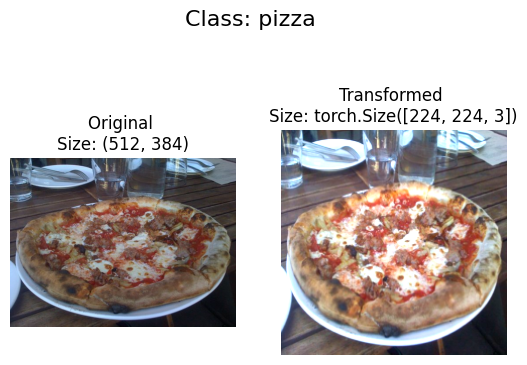

In [36]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                       n=3)

# 7. Model 0: TinyVGG without data augmentation

In [37]:
# Create a simple transform 
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [38]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os 
from torch.utils.data import DataLoader

BATCH_SIZE = 32 
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_simple = DataLoader(train_data_simple, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=True, 
                                    num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 16 workers.


(<torch.utils.data.dataloader.DataLoader at 0x2116e97a720>,
 <torch.utils.data.dataloader.DataLoader at 0x2116e978470>)

## 7.2 Create TinyVGG model class

In [39]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int)-> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     padding=1,
                     stride=1), # default),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     padding=1,
                     stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                     out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)

        return x
torch.manual_seed(42)

model0 = TinyVGG(input_shape=3, 
                hidden_units=10,
                output_shape=len(train_data.classes)).to(device)

model0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [40]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model0.eval()
with torch.inference_mode():
    pred = model0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")
pred.shape

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


torch.Size([1, 3])

## 7.4 Use torchinfo to get an idea of the shapes going through our model
- torchinfo comes with a summary() method that takes a PyTorch model as well as an input_shape and returns what happens as a tensor moves through your model.

In [41]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo 
    import torchinfo 

from torchinfo import summary
summary(model0, input_size=[1, 3, 64, 64])  # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 7.5 Create train & test loop functions

In [42]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

    

In [43]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module):
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

## 7.6 Creating a train() function to combine train_step() and test_step()

In [44]:
from tqdm.auto import tqdm 

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
         epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
          }
     # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    return results

## 7.7 Train and Evaluate Model 0

In [45]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set nums of epochs 
EPOCHS = 5

model0 = TinyVGG(3, 10, len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

model0_results = train(model=model0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=EPOCHS)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1623 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1155 | train_acc: 0.2930 | test_loss: 1.1698 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0976 | train_acc: 0.4141 | test_loss: 1.1358 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.2930 | test_loss: 1.1422 | test_acc: 0.1979
Total training time: 223.486 seconds


## 7.8 Plot the loss curves of Model 0

In [46]:
# Check the model_0_results keys
model0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [47]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

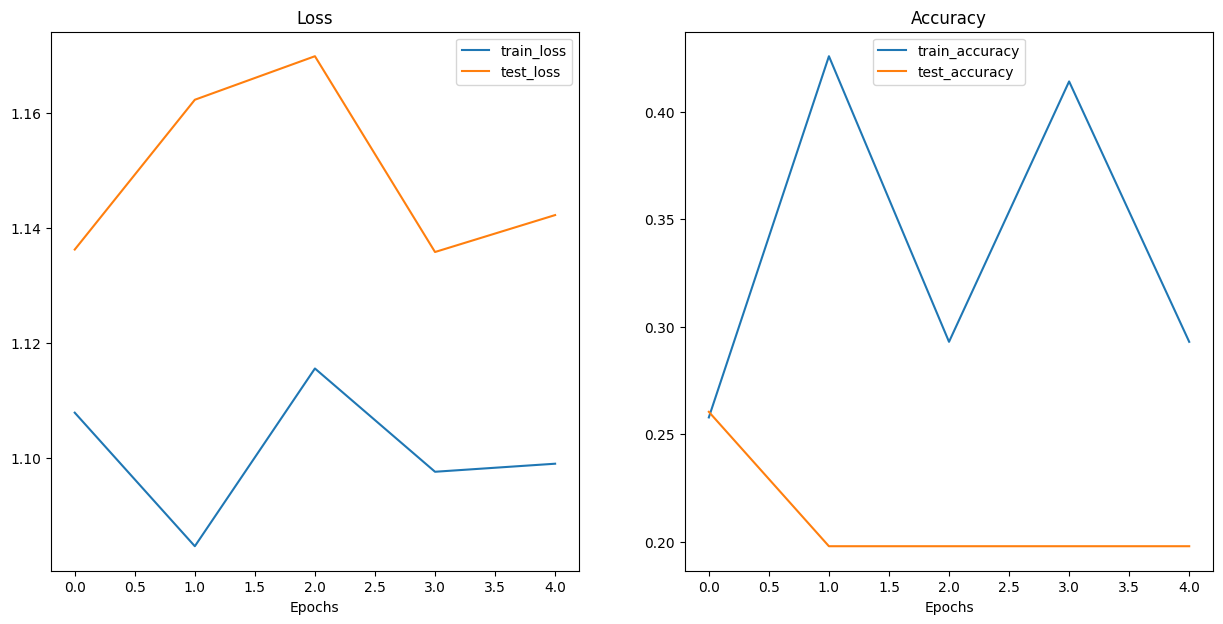

In [48]:
plot_loss_curves(model0_results)

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="Alt Text" width="500">

- How to deal with overfitting
<br>

<a href="https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting">Common Ways to prevent overfitting</a>
<br>
<a href="https://www.learnpytorch.io/04_pytorch_custom_datasets/#82-how-to-deal-with-underfitting">Common Ways to prevent underfitting</a>

# 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [49]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

### 9.2 Create train and test Dataset's and DataLoader's

In [50]:
from torchvision import datasets 
train_data_augmented = datasets.ImageFolder(train_dir, train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, test_transforms)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [51]:
import os 
BATCH_SIZE = 32 
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True, 
                                       num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x2116e97b080>,
 <torch.utils.data.dataloader.DataLoader at 0x2116e77ecf0>)

In [52]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model1 = TinyVGG(input_shape=3, hidden_units=10, 
                output_shape=len(train_data_augmented.classes)).to(device)

model1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [54]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set nums of epochs 
NUM_EPOCHS = 5 

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.001)

# Start timer 
from timeit import default_timer as timer

start_time = timer()

model1_results = train(model=model1, 
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1385 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1620 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1477 | test_acc: 0.2604
Total training time: 213.532 seconds


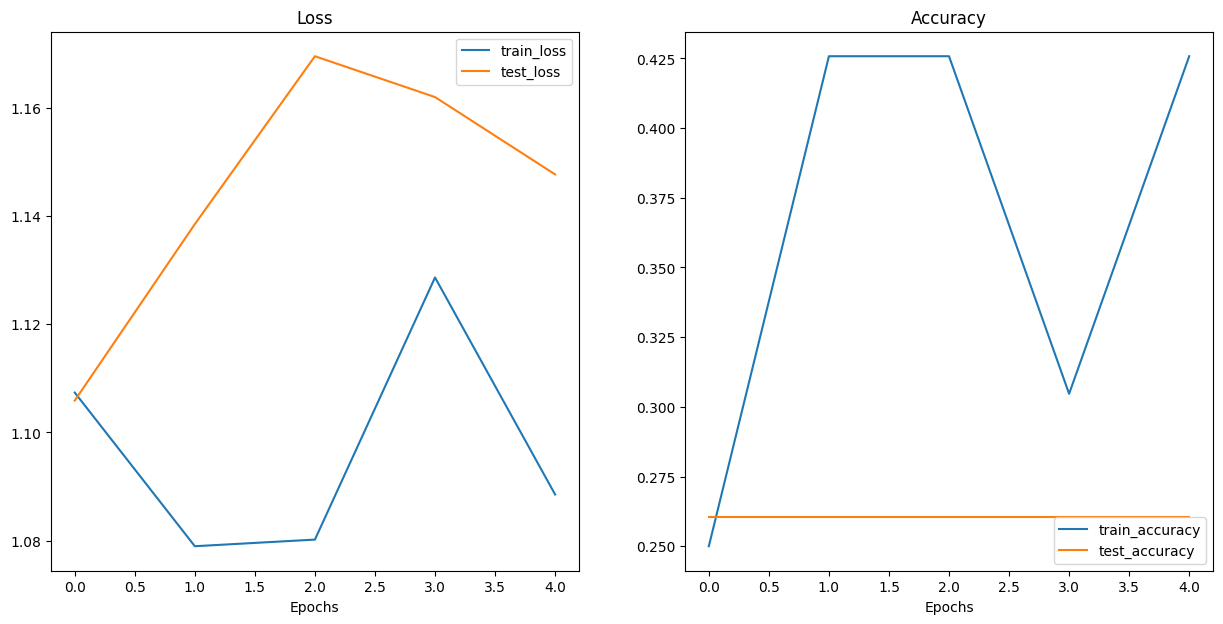

In [55]:
plot_loss_curves(model1_results)

## 10. Compare model results

In [57]:
import pandas as pd 
model0_df = pd.DataFrame(model0_results)
model1_df = pd.DataFrame(model1_results)
model0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107837,0.257812,1.136213,0.260417
1,1.084604,0.425781,1.162271,0.197917
2,1.115522,0.292969,1.169844,0.197917
3,1.097557,0.414062,1.135785,0.197917
4,1.098957,0.292969,1.142210,0.197917


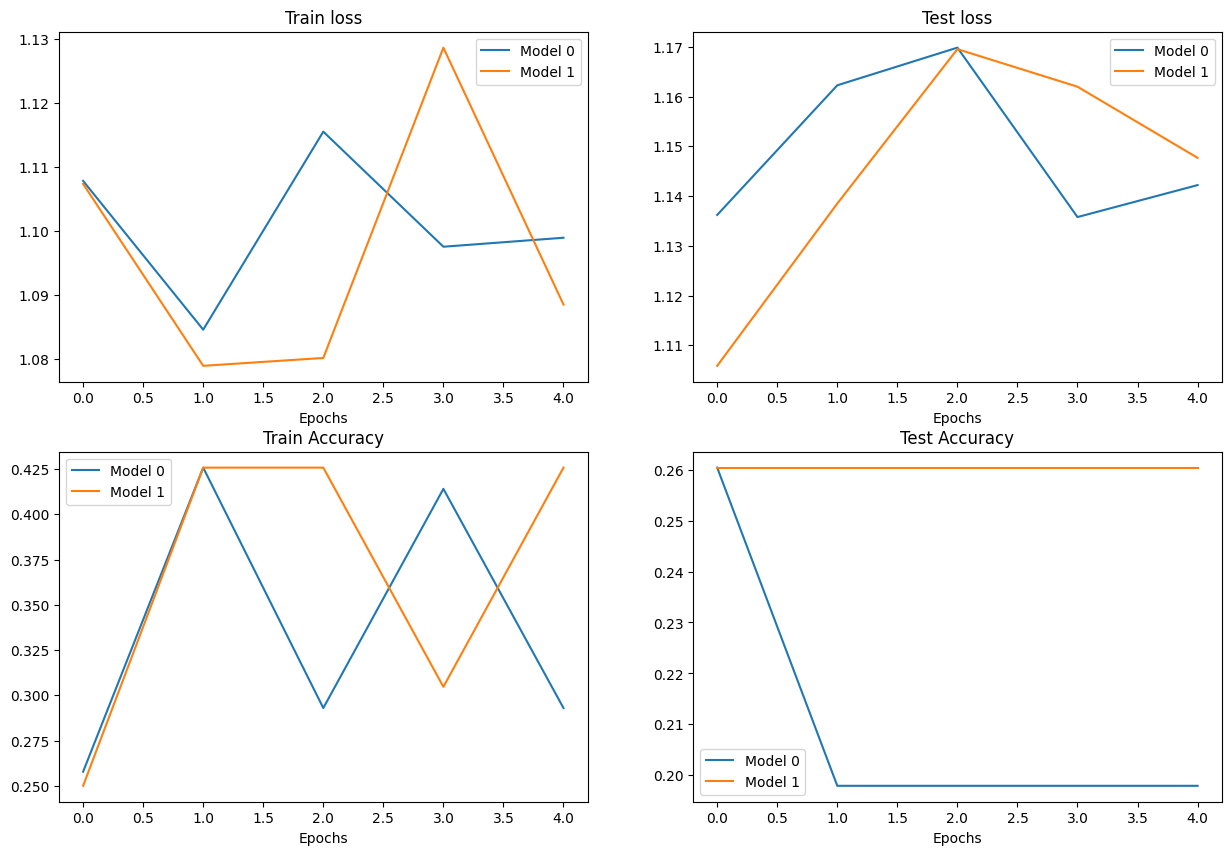

In [59]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get num of epochs 
epochs = range(len(model0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model0_df["train_loss"], label="Model 0")
plt.plot(epochs, model1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model0_df["test_loss"], label="Model 0")
plt.plot(epochs, model1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model0_df["train_acc"], label="Model 0")
plt.plot(epochs, model1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model0_df["test_acc"], label="Model 0")
plt.plot(epochs, modelb1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11.1 Loading in a custom image with PyTorch

- PyTorch's torchvision has several input and output ("IO" or "io" for short) methods for reading and writing images and video in torchvision.io.

- Since we want to load in an image, we'll use torchvision.io.read_image().

- This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255].

In [61]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [63]:
import torchvision 

# Read in custom image
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n{custom_image_unit8}\n")
print(f"Custom image shape: {custom_image_unit8.shape}\n")
print(f"Custom image dtype: {custom_image_unit8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [64]:
# Try to make a prediction on image in uint8 format (this will error)
model1.eval()
with torch.inference_mode():
    model1(custom_image_unit8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [65]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Normalizing 
custom_image /= 255

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

## 11.2 Predicting on custom images with a trained PyTorch model

(-0.5, 3023.5, 4031.5, -0.5)

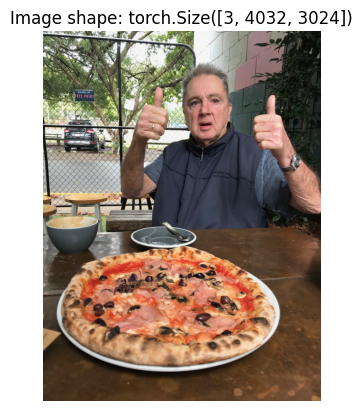

In [67]:
# Plot custom image 
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [68]:
# Create transform pipleine to resize image
custom_image_transfrom = transforms.Compose([
    transforms.Resize((64, 64))
])

custom_image_transformed = custom_image_transfrom(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [69]:
model1.eval()

with torch.inference_mode():
    custom_image_pred = model1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [70]:
model1.eval()

with torch.inference_mode():
    custom_image_pred = model1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [74]:
model1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batchsize = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batchsize.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model1(custom_image_transformed_with_batchsize.to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


- Note: What we've just gone through are three of the classical and most common deep learning and PyTorch issues:

1. Wrong datatypes - our model expects torch.float32 where our original custom image was uint8.
2. Wrong device - our model was on the target device (in our case, the GPU) whereas our target data hadn't been moved to the target device yet.
3. Wrong shapes - our model expected an input image of shape [N, C, H, W] or [batch_size, color_channels, height, width] whereas our custom image tensor was of shape [color_channels, height, width].

In [75]:
custom_image_pred

tensor([[ 0.1184,  0.0274, -0.1458]], device='cuda:0')

In [78]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label.item()}")


Prediction logits: tensor([[ 0.1184,  0.0274, -0.1458]], device='cuda:0')
Prediction probabilities: tensor([[0.3730, 0.3406, 0.2864]], device='cuda:0')
Prediction label: 0


In [79]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'pizza'

In [82]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

# Having prediction probabilities this similar could mean a couple of things:
# The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
# The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

tensor([[0.3730, 0.3406, 0.2864]], device='cuda:0')